# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Final Project: Mobility Data and Coronavirus Cases in the United States

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2.4pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
import tensorflow as tf


In [315]:
# read in the dataframes
national_df = pd.read_csv("../../02_Data/05_Mobility/US_Mobility_Report.csv")
state_df = pd.read_csv("../../02_Data/05_Mobility/US_States_Mobility_Report.csv")
county_df = pd.read_csv("../../02_Data/05_Mobility/US_Regional_Mobility_Report.csv")
cases_df = pd.read_csv("../../02_Data/01_Covid/covid_us_county.csv")

county_df_raw = pd.read_csv("../../02_Data/05_Mobility/US_Regional_Mobility_Report_raw.csv")
county_df1 = pd.read_csv("../../02_Data/05_Mobility/US_Regional_Mobility_Report1.csv")


In [316]:
print(national_df.shape)
print(state_df.shape)
print(county_df.shape)
print(county_df_raw.shape)
print(county_df1.shape)

print(cases_df.shape)

(263, 8)
(13413, 9)
(646449, 10)
(646449, 10)
(646449, 10)
(945220, 9)


In [248]:
cdf = county_df.copy()

In [250]:
cdf = cdf.dropna()

In [253]:
cdf.describe()

,census_fips_code,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
count,108458.000000,108458.000000,108458.000000,108458.000000,108458.000000,108458.000000,108458.000000
mean,28561.687363,-18.502277,-3.571336,37.282413,-20.868530,-28.794142,9.537664
std,16168.818965,18.499880,12.349925,63.897646,24.528177,17.294614,7.144256
min,1003.000000,-98.000000,-96.000000,-90.000000,-92.000000,-88.000000,-26.000000
25%,12127.000000,-31.000000,-11.000000,-6.000000,-38.000000,-41.000000,4.000000
50%,29095.000000,-17.000000,-3.000000,24.000000,-21.000000,-32.000000,9.000000
75%,42079.000000,-6.000000,4.000000,68.000000,-2.000000,-17.000000,14.000000
max,56025.000000,152.000000,70.000000,658.000000,222.000000,27.000000,38.000000


In [254]:
cdf.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
257,Alabama,Baldwin County,1003.0,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0
258,Alabama,Baldwin County,1003.0,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0
259,Alabama,Baldwin County,1003.0,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0
260,Alabama,Baldwin County,1003.0,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0
261,Alabama,Baldwin County,1003.0,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0


In [247]:
county_df.notnull().sum()

sub_region_1             646449
sub_region_2             646449
census_fips_code         646449
date                     646449
retail_and_recreation    429839
grocery_and_pharmacy     390907
parks                    139099
transit_stations         236034
workplaces               623888
residential              326640
dtype: int64

In [232]:
county_df_raw.isnull().sum()

sub_region_1                  0
sub_region_2                  0
census_fips_code              0
date                          0
retail_and_recreation    216610
grocery_and_pharmacy     255542
parks                    507350
transit_stations         410415
workplaces                22561
residential              319809
dtype: int64

In [233]:
county_df.isnull().sum()

sub_region_1                  0
sub_region_2                  0
census_fips_code              0
date                          0
retail_and_recreation    216610
grocery_and_pharmacy     255542
parks                    507350
transit_stations         410415
workplaces                22561
residential              319809
dtype: int64

In [226]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

fips           2830
county         1698
state_code    25187
dtype: int64

In [208]:
county_df.isnull().sum()

sub_region_1                  0
sub_region_2                  0
census_fips_code              0
date                          0
retail_and_recreation    216610
grocery_and_pharmacy     255542
parks                    507350
transit_stations         410415
workplaces                22561
residential              319809
dtype: int64

In [309]:
county_df = county_df.dropna()

In [210]:
county_df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
257,Alabama,Baldwin County,1003.0,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0
258,Alabama,Baldwin County,1003.0,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0
259,Alabama,Baldwin County,1003.0,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0
260,Alabama,Baldwin County,1003.0,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0
261,Alabama,Baldwin County,1003.0,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0


In [163]:
county_df.loc[county_df['sub_region_1'] == 'District of Columbia']

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential


In [310]:
county_df.isnull().any()

sub_region_1             False
sub_region_2             False
census_fips_code         False
date                     False
retail_and_recreation    False
grocery_and_pharmacy     False
parks                    False
transit_stations         False
workplaces               False
residential              False
dtype: bool

In [114]:
cases_df.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


In [311]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

Series([], dtype: float64)

In [235]:
cases_df_raw = cases_df.copy()

In [236]:
drop_index = (cases_df.loc[(cases_df['state'] == 'American Samoa') | (cases_df['state'] == 'Virgin Islands')]).index
cases_df = cases_df.drop(index = drop_index)

In [237]:
drop_index = (cases_df.loc[(cases_df['state'] == 'Diamond Princess') | (cases_df['state'] == 'Puerto Rico')]).index
cases_df = cases_df.drop(index = drop_index)

In [238]:
drop_index = (cases_df.loc[(cases_df['state'] == 'Northern Mariana Islands') | (cases_df['state'] == 'District of Columbia')]).index
cases_df = cases_df.drop(index = drop_index)

In [239]:
drop_index = (cases_df.loc[(cases_df['state'] == 'Grand Princess') | (cases_df['state'] == 'Guam')]).index
cases_df = cases_df.drop(index = drop_index)

In [263]:
cases_df.loc[cases_df['fips'].isnull()]

,fips,county,state,lat,long,date,cases,state_code,deaths
358561,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,2020-01-22,0,MA,0
358562,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,2020-01-23,0,MA,0
358563,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,2020-01-24,0,MA,0
358564,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,2020-01-25,0,MA,0
358565,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,2020-01-26,0,MA,0
...,...,...,...,...,...,...,...,...,...
846448,NaN,Weber-Morgan,Utah,41.271160,-111.914512,2020-10-26,6477,UT,33
846449,NaN,Weber-Morgan,Utah,41.271160,-111.914512,2020-10-27,6565,UT,33
846450,NaN,Weber-Morgan,Utah,41.271160,-111.914512,2020-10-28,6691,UT,36
846451,NaN,Weber-Morgan,Utah,41.271160,-111.914512,2020-10-29,6840,UT,36


In [241]:
cases_df_copy = cases_df.copy()

In [242]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

fips    2830
dtype: int64

In [264]:
# drop all null columns
cases_df = cases_df.dropna()
cases_df.isnull().any()
# cases_df.loc[cases_df['state_code'].isnull()]

fips          False
county        False
state         False
lat           False
long          False
date          False
cases         False
state_code    False
deaths        False
dtype: bool

In [255]:
cases_df.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


In [246]:
county_df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Alabama,Autauga County,1001.0,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga County,1001.0,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga County,1001.0,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga County,1001.0,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga County,1001.0,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [256]:
cases_df.describe()

,fips,lat,long,cases,deaths
count,917203.000000,920033.000000,920033.000000,920033.000000,920033.000000
mean,32075.704104,37.252499,-89.427120,915.922803,31.838312
std,17684.386718,8.495763,20.532721,5422.543345,232.330842
min,1001.000000,0.000000,-174.159600,0.000000,0.000000
25%,19045.000000,34.267441,-98.075784,0.000000,0.000000
50%,30047.000000,38.172154,-89.917162,34.000000,0.000000
75%,47007.000000,41.684477,-82.846913,308.000000,6.000000
max,90056.000000,69.314792,0.000000,306327.000000,7400.000000


In [258]:
cdf.shape

(108458, 10)

In [262]:
cases_df.isnull().any()

fips           True
county        False
state         False
lat           False
long          False
date          False
cases         False
state_code    False
deaths        False
dtype: bool

In [257]:
county_df.describe()

,census_fips_code,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
count,646449.000000,429839.000000,390907.000000,139099.000000,236034.000000,623888.000000,326640.000000
mean,30371.007798,-8.856404,2.091590,34.218053,-10.445639,-22.775727,7.395539
std,15297.340983,20.415382,14.679011,63.943777,26.182542,14.829930,6.233830
min,1001.000000,-100.000000,-96.000000,-91.000000,-92.000000,-92.000000,-46.000000
25%,18107.000000,-21.000000,-6.000000,-9.000000,-28.000000,-32.000000,3.000000
50%,29119.000000,-7.000000,1.000000,21.000000,-8.000000,-24.000000,6.000000
75%,45051.000000,4.000000,9.000000,65.000000,7.000000,-14.000000,11.000000
max,56045.000000,261.000000,225.000000,709.000000,252.000000,66.000000,38.000000


Let's join the dataframes by fips code, states, counties, and date.

In [318]:
df = county_df.merge(cases_df, left_on=['census_fips_code', 'sub_region_1', 'sub_region_2', 'date'], right_on=['fips', 'state', 'county', 'date'])

In [319]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,county,state,lat,long,cases,state_code,deaths
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0


In [320]:
df.describe()

,census_fips_code,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,lat,long,cases,deaths
count,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000
mean,41250.952942,-12.469388,0.197543,34.649198,-14.724787,-26.656430,7.548940,41250.952942,42.310010,-92.801089,526.655439,9.152368
std,19828.063492,15.858597,9.710881,22.358072,15.791912,15.838237,4.240717,19828.063492,9.676261,27.819737,1087.052447,16.779480
min,2020.000000,-78.000000,-50.000000,-68.000000,-77.000000,-88.000000,-6.000000,2020.000000,36.580224,-159.856183,0.000000,0.000000
25%,51510.000000,-19.000000,-4.000000,34.000000,-11.000000,-36.000000,7.000000,51510.000000,36.933571,-82.163591,4.000000,0.000000
50%,51640.000000,-9.000000,2.000000,34.000000,-10.000000,-28.000000,7.000000,51640.000000,37.734846,-78.875363,86.000000,1.000000
75%,51730.000000,-5.000000,3.000000,34.000000,-10.000000,-17.000000,7.000000,51730.000000,38.884853,-77.175608,445.750000,8.000000
max,51840.000000,58.000000,88.000000,271.000000,46.000000,26.000000,34.000000,51840.000000,69.314792,-76.045669,8149.000000,108.000000


In [268]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,county,state,lat,long,cases,state_code,deaths
0,Alaska,Anchorage,2020.0,2020-02-15,5.0,3.0,11.0,3.0,0.0,0.0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
1,Alaska,Anchorage,2020.0,2020-02-16,15.0,3.0,43.0,6.0,3.0,-1.0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
2,Alaska,Anchorage,2020.0,2020-02-17,4.0,0.0,-2.0,-10.0,-36.0,10.0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
3,Alaska,Anchorage,2020.0,2020-02-18,-5.0,-1.0,-19.0,3.0,1.0,2.0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
4,Alaska,Anchorage,2020.0,2020-02-19,-1.0,-3.0,-8.0,5.0,1.0,1.0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0


In [269]:
type(df.iloc[0]['date'])
df_copy = df.copy()

In [270]:
# df.groupby('fips', as_index=False).mean()['retail_and_recreation']

In [321]:
# save all predictors in its own variable
predictors_list = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

In [322]:
# df.groupby('fips', as_index=False).shift(periods=1, fill_value=0)

In [323]:
# add in the 7 day average for the cases and deaths
df['cases_7day_ave'] = df.groupby('fips', as_index=False)['cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)
df['deaths_7day_ave'] = df.groupby('fips', as_index=False)['deaths'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)

In [324]:
# now do the same for the 6 predictors
for i in range(len(predictors_list)):
    df[f'{predictors_list[i]}_7day_ave'] = df.groupby('fips', as_index=False)[predictors_list[i]].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)

In [325]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,state_code,deaths,cases_7day_ave,deaths_7day_ave,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,...,AK,0,0.0,0.0,2.714286,0.571429,2.571429,1.428571,-3.428571,1.714286
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,...,AK,0,0.0,0.0,2.857143,0.571429,2.714286,1.428571,-3.000000,1.571429


Let's include facemask data below.

In [326]:
# facemask
df_facemask = pd.read_csv(r"../../02_Data/07_Facemask/county_facemask.csv",index_col=0)
df_facemask['facemask_score']=1*df_facemask['facemask_never']+2*df_facemask['facemask_rarely']+3*df_facemask['facemask_sometimes']+4*df_facemask['facemask_frequently']+5*df_facemask['facemask_always']
df_facemask=df_facemask.drop(columns='countyfp')
df_facemask.describe()

,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,fips,facemask_score
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,0.079940,0.082919,0.121318,0.207725,0.508094,30383.649268,3.981097
std,0.058538,0.055464,0.058011,0.063571,0.152191,15162.508374,0.413002
min,0.000000,0.000000,0.001000,0.029000,0.115000,1001.000000,2.433000
25%,0.034000,0.040000,0.079000,0.164000,0.393250,18177.500000,3.682000
50%,0.068000,0.073000,0.115000,0.204000,0.497000,29176.000000,3.992000
75%,0.113000,0.115000,0.156000,0.247000,0.613750,45080.500000,4.291750
max,0.432000,0.384000,0.422000,0.549000,0.889000,56045.000000,4.849000


In [327]:
df = df.merge(df_facemask, on='fips')

In [328]:
df.isnull().any()

sub_region_1                      False
sub_region_2                      False
census_fips_code                  False
date                              False
retail_and_recreation             False
grocery_and_pharmacy              False
parks                             False
transit_stations                  False
workplaces                        False
residential                       False
fips                              False
county                            False
state                             False
lat                               False
long                              False
cases                             False
state_code                        False
deaths                            False
cases_7day_ave                    False
deaths_7day_ave                   False
retail_and_recreation_7day_ave    False
grocery_and_pharmacy_7day_ave     False
parks_7day_ave                    False
transit_stations_7day_ave         False
workplaces_7day_ave               False


In [280]:
# save raw df before work is done on it
df_raw = df.copy()

In [279]:
# drop nulls -- I don't think there are any though
df = df.dropna()

Now, hopefully, everything is matched up properly

In [281]:
# drop the lats and longs
df = df.drop(columns=['lat', 'long'])

In [329]:
df.describe()

,census_fips_code,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,lat,long,...,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,facemask_score
count,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,...,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000
mean,41250.952942,-12.469388,0.197543,34.649198,-14.724787,-26.656430,7.548940,41250.952942,42.310010,-92.801089,...,33.877735,-14.399049,-26.202143,7.375343,0.041748,0.045904,0.087556,0.201728,0.622946,4.317869
std,19828.063492,15.858597,9.710881,22.358072,15.791912,15.838237,4.240717,19828.063492,9.676261,27.819737,...,17.279182,14.386024,13.927057,3.688501,0.037808,0.031883,0.053802,0.065314,0.118049,0.270985
min,2020.000000,-78.000000,-50.000000,-68.000000,-77.000000,-88.000000,-6.000000,2020.000000,36.580224,-159.856183,...,-42.142857,-69.714286,-62.571429,-1.857143,0.000000,0.001000,0.001000,0.075000,0.352000,3.501000
25%,51510.000000,-19.000000,-4.000000,34.000000,-11.000000,-36.000000,7.000000,51510.000000,36.933571,-82.163591,...,34.000000,-14.142857,-34.428571,7.000000,0.017000,0.025000,0.049000,0.163000,0.565000,4.217000
50%,51640.000000,-9.000000,2.000000,34.000000,-10.000000,-28.000000,7.000000,51640.000000,37.734846,-78.875363,...,34.000000,-10.000000,-27.571429,7.000000,0.033000,0.039000,0.073000,0.196000,0.639000,4.380000
75%,51730.000000,-5.000000,3.000000,34.000000,-10.000000,-17.000000,7.000000,51730.000000,38.884853,-77.175608,...,34.000000,-10.000000,-20.142857,7.428571,0.051000,0.056000,0.129000,0.225000,0.710000,4.505000
max,51840.000000,58.000000,88.000000,271.000000,46.000000,26.000000,34.000000,51840.000000,69.314792,-76.045669,...,150.571429,26.428571,20.857143,28.000000,0.184000,0.150000,0.235000,0.450000,0.833000,4.707000


In [330]:
# check for nulls
df.isnull().any().sum()

0

In [331]:
# split between predictors and response variables
X = df.drop(columns=['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave'])
y = df[['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave']]

In [332]:
y.head()

,cases,deaths,cases_7day_ave,deaths_7day_ave
0,0,0,0.0,0.0
1,0,0,0.0,0.0
2,0,0,0.0,0.0
3,0,0,0.0,0.0
4,0,0,0.0,0.0


In [333]:
# split between train and test data -- for covid deaths
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=111)
X_train, X_test, y_train, y_test = X_train_raw, X_test_raw, y_train_raw, y_test_raw
print(f"The shape of: \n"
      f"X_train is {X_train.shape}\n"
      f"X_test is {X_test.shape}\n"
      f"y_train is {y_train.shape}\n"
      f"y_test is {y_test.shape}\n")

The shape of: 
X_train is (7065, 28)
X_test is (3029, 28)
y_train is (7065, 4)
y_test is (3029, 4)



Let's try a different type of model now

As we can see, we need about half the components to explain at least 90% of the variance.

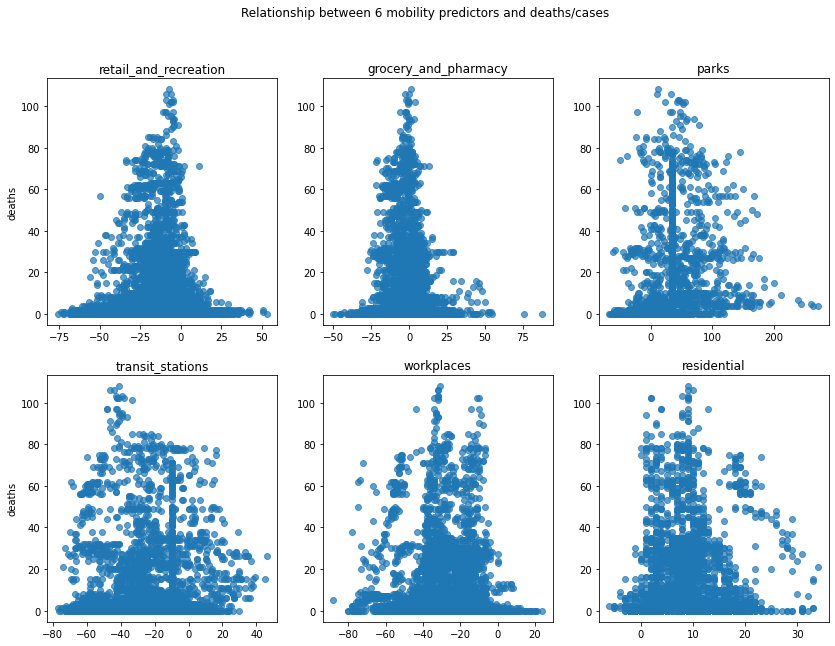

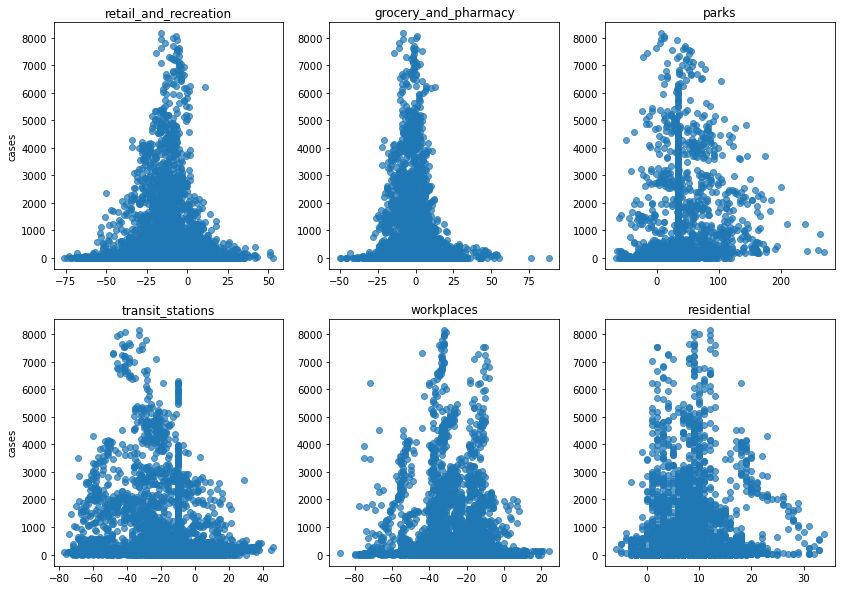

In [334]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 6 mobility predictors and deaths/cases")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['cases'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("cases")
    i += 1

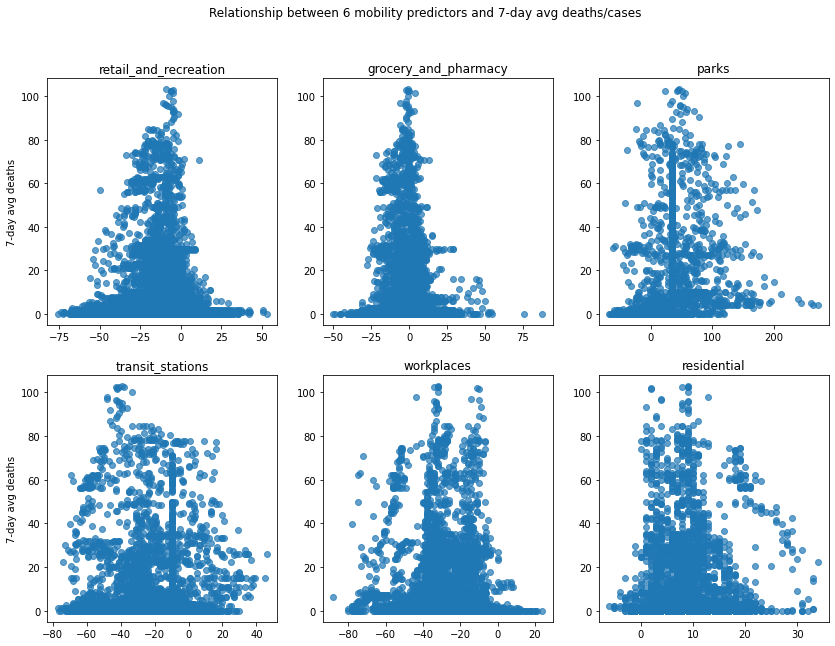

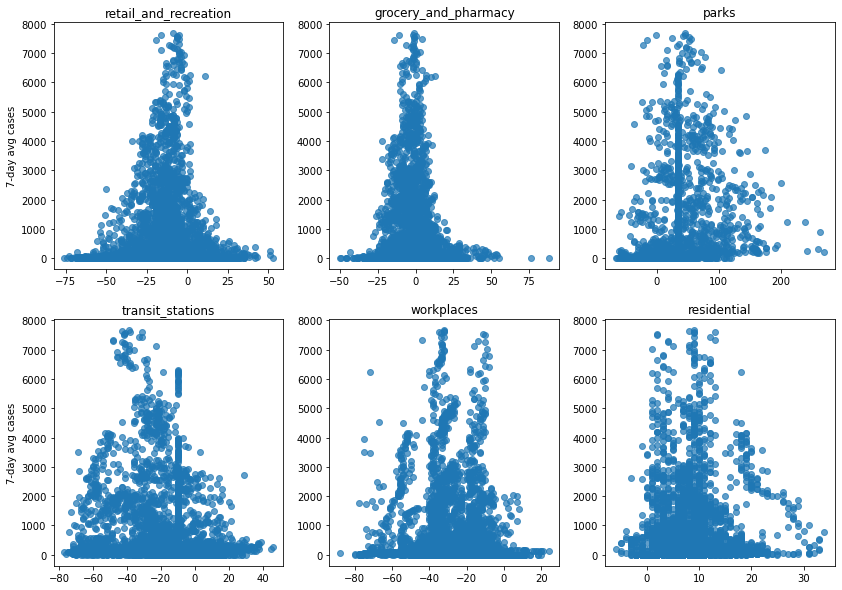

In [335]:
## let's check out the same but with 7-day average deaths and cases

fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 6 mobility predictors and 7-day avg deaths/cases")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths_7day_ave'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("7-day avg deaths")
    i += 1
    
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['cases_7day_ave'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("7-day avg cases")
    i += 1

Now let's predict deaths on each of the 6 mobility predictors individually.

In [336]:
%%time

train_mses = {}
test_mses = {}

train_r2_dict = {}
test_r2_dict = {}

for i in range(len(predictors_list)):
    poly = PolynomialFeatures(4)
    x_train = poly.fit_transform(X_train[[predictors_list[i]]])

    # Train our model
    model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
    model.fit(x_train, y_train['deaths'])
    y_pred_train = model.predict(x_train)

    # Test our model
    x_test = poly.fit_transform(X_test[[predictors_list[i]]])
    y_pred_test = model.predict(x_test)
    
    # Calculate MSEs
    test_mse = mean_squared_error(y_pred_test, y_test["deaths"])
    train_mse = mean_squared_error(y_pred_train, y_train["deaths"])
    
    # Calculate r2
    test_r2 = r2_score(y_test["deaths"], y_pred_test)
    train_r2 = r2_score(y_train["deaths"], y_pred_train)
    
    train_mses.update([(predictors_list[i], train_mse)])
    test_mses.update([(predictors_list[i], test_mse)])
    
    train_r2_dict.update([(predictors_list[i], train_r2)])
    test_r2_dict.update([(predictors_list[i], test_r2)])

CPU times: user 219 ms, sys: 93.8 ms, total: 312 ms
Wall time: 80.2 ms


In [337]:
print("Train MSEs")
print(train_mses)
print("Test MSEs")
print(test_mses)
print("")
print("Train R^2")
print(train_r2_dict)
print("Test R^2")
print(test_r2_dict)

Train MSEs
{'retail_and_recreation': 269.2024684755076, 'grocery_and_pharmacy': 273.99831856341217, 'parks': 273.5264965091199, 'transit_stations': 254.34055163420408, 'workplaces': 276.01015667783537, 'residential': 276.54473541496606}
Test MSEs
{'retail_and_recreation': 265.97977248341806, 'grocery_and_pharmacy': 269.8720865305806, 'parks': 272.3526448034066, 'transit_stations': 245.5269794815114, 'workplaces': 272.9276422841646, 'residential': 270.8137672698257}

Train R^2
{'retail_and_recreation': 0.046626549592318045, 'grocery_and_pharmacy': 0.0296421728448234, 'parks': 0.031313118220719804, 'transit_stations': 0.09925963657292536, 'workplaces': 0.02251730116117534, 'residential': 0.020624104646228658}
Test R^2
{'retail_and_recreation': 0.048542225330206135, 'grocery_and_pharmacy': 0.03461871367722846, 'parks': 0.02574530788337659, 'transit_stations': 0.12170556678914812, 'workplaces': 0.02368843785008512, 'residential': 0.03125015127774222}


As we can see, predicting deaths on individual predictors does not work well. Let's try using all mobility predictors.

In [338]:
# Use this function to calculate a polynomial regression, given a list of predictors
def polynomial_regression(y_var_train, y_var_test, list_of_predictors, verbose=True):
    poly = PolynomialFeatures(4)
    x_train = poly.fit_transform(X_train[list_of_predictors])

    # Train our model
    model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
    model.fit(x_train, y_var_train)

    # Test our model
    y_pred_train = model.predict(x_train)
    x_test = poly.fit_transform(X_test[list_of_predictors])
    y_pred_test = model.predict(x_test)

    # Calculate MSEs
    test_mse = mean_squared_error(y_var_test, y_pred_test)
    train_mse = mean_squared_error(y_var_train, y_pred_train)

    # Calculate r2
    test_r2 = r2_score(y_var_test, y_pred_test)
    train_r2 = r2_score(y_var_train, y_pred_train)
    
    # Go ahead and print what we want
    if verbose:
        print(f"The MSE is {train_mse} for train")
        print(f"r^2 is {train_r2} for train\n")
        print(f"The MSE is {test_mse} for test")
        print(f"r^2 is {test_r2} for test")

    # Just in case, return relevant information
    return train_mse, test_mse, train_r2, test_r2


In [339]:
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['deaths'], y_test['deaths'], predictors_list)

The MSE is 174.26428165480976 for train
r^2 is 0.38284763722670834 for train

The MSE is 198.1559540646157 for test
r^2 is 0.2911602963956852 for test


In [340]:
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases'], y_test['cases'], predictors_list)

The MSE is 665957.908543281 for train
r^2 is 0.43716142734859276 for train

The MSE is 810675.8382365559 for test
r^2 is 0.311651717696135 for test


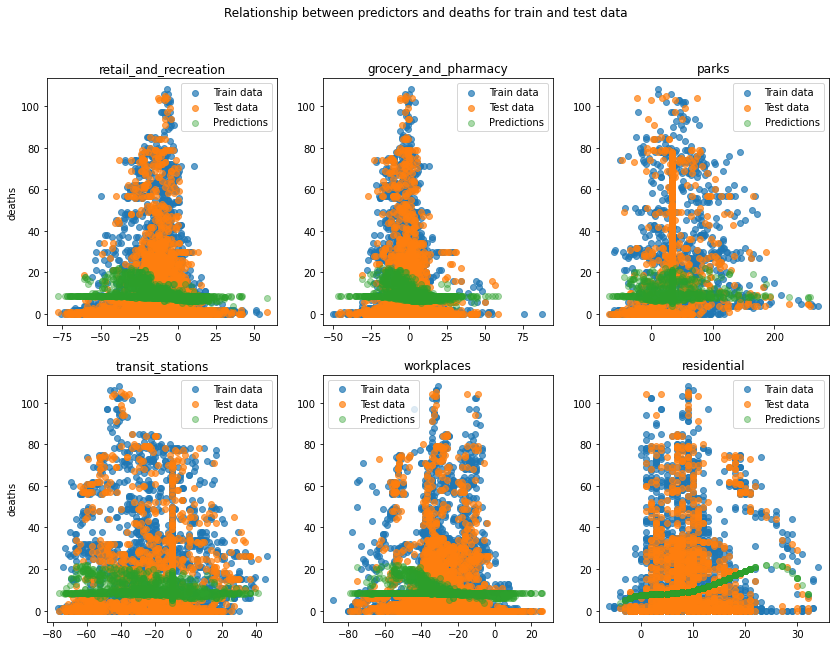

In [341]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between predictors and deaths for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths'], alpha=0.7, label="Train data")
    ax.scatter(X_test[predictors_list[i]], y_test['deaths'], alpha=0.7, label="Test data")
    ax.scatter(X_test[predictors_list[i]], y_pred_test, alpha=0.4, label="Predictions")
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    ax.legend()


Now let's analyze using a bagging regression model. Use all mobility predictors and predict deaths.

In [342]:
# Use this function to calculate a decision tree regression, given a list of predictors
def bagging_regression(y_var_train, y_var_test, list_of_predictors, verbose=True):
    num_bootstraps = 80
    max_depth = 65

    # Define the Bagging Regressor Model
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth),n_estimators=num_bootstraps)

    # Fit the model on the train data
    model.fit(X_train[list_of_predictors], y_var_train)
    
    # Test our model
    y_pred_train = model.predict(X_train[list_of_predictors])
    y_pred_test = model.predict(X_test[list_of_predictors])
    
    # Calculate MSEs
    test_mse = mean_squared_error(y_var_test, y_pred_test)
    train_mse = mean_squared_error(y_var_train, y_pred_train)
    
    # Calculate r2
    test_r2 = r2_score(y_var_test, y_pred_test)
    train_r2 = r2_score(y_var_train, y_pred_train)

    # print predictions if verbose
    if verbose:
        print(f"The MSE for train set on all the predictors is {train_mse}")
        print(f"r^2 on all the predictors is {train_r2} for train\n")

        print(f"The MSE for test set on all the predictors is {test_mse}")
        print(f"r^2 on all the predictors is {test_r2} for test")
    
    # Just in case, return relevant information
    return train_mse, test_mse, train_r2, test_r2

In [343]:
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['deaths'], y_test['deaths'], predictors_list)

The MSE for train set on all the predictors is 16.490356366143306
r^2 on all the predictors is 0.941599837340746 for train

The MSE for test set on all the predictors is 98.0799857530166
r^2 on all the predictors is 0.6491501435883511 for test


Now let's do the same to predict cases. Again, use all mobility predictors.

In [344]:
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], predictors_list)

The MSE for train set on all the predictors is 53471.875628143986
r^2 on all the predictors is 0.954807903368292 for train

The MSE for test set on all the predictors is 354550.87037717283
r^2 on all the predictors is 0.6989493566943439 for test


As we can see, the test data's r^2 improved a bit. It was around 0.64 when predicting deaths, but now it is around 0.70 when predicting cases. This suggests that using same-day mobility data is a better indicator for predicting cases rather than deaths.

Now let's fit on the individual mobility predictors again, and see what happens.

In [345]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['deaths'], y_test['deaths'], 
                                                                [predictors_list[i]], verbose=False)

    bagg_mses_train.update([(predictors_list[i], train_mse)])
    bagg_mses_test.update([(predictors_list[i], test_mse)])
    
    bagg_r2_train.update([(predictors_list[i], train_r2)])
    bagg_r2_test.update([(predictors_list[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,242.628043,255.541710,235.403106,235.638482,259.630541,217.553445
R2,0.140739,0.095006,0.166326,0.165493,0.080525,0.229540


Test set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,240.940026,256.017214,270.867545,244.707670,258.239888,229.430755
R2,0.138114,0.084180,0.031058,0.124636,0.076229,0.179285


As expected, the MSE increased quite a bit, and the r^2 is much lower than when using all the predictors. This suggests we are better served to use all mobility predictors, however, let's plot the MSEs and r^2 values for the 6 mobility predictors and see if we can begin to tell which ones are better than others.

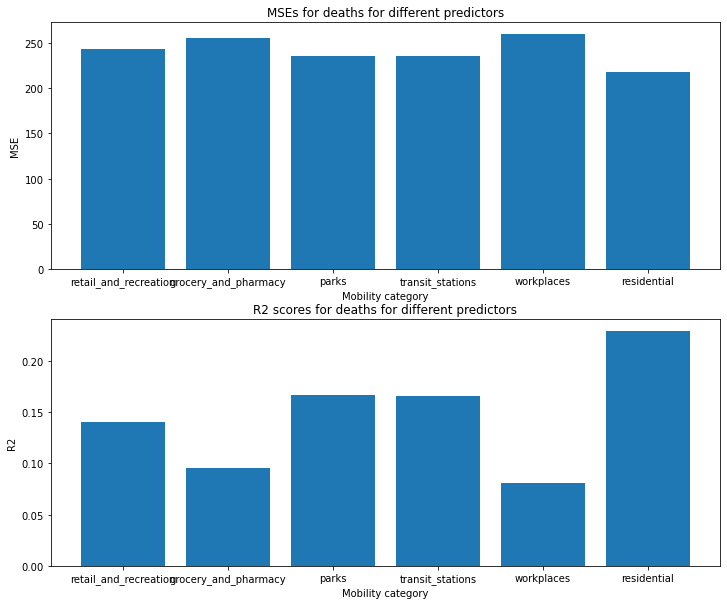

In [346]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(predictors_list, train_list_mse)
axs[0].set_title("MSEs for deaths for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(predictors_list, train_list_r2)
axs[1].set_title("R2 scores for deaths for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")


fig.show()

Now do the same but examine cases instead of deaths. We expect the same trend - i.e. that parks, transit stations, and residential are better predictors than the other 3.

In [347]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], 
                                                                [predictors_list[i]], verbose=False)

    bagg_mses_train.update([(predictors_list[i], train_mse)])
    bagg_mses_test.update([(predictors_list[i], test_mse)])
    
    bagg_r2_train.update([(predictors_list[i], train_r2)])
    bagg_r2_test.update([(predictors_list[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,1.038095e+06,1.067795e+06,917175.110665,927271.484636,1.091839e+06,887428.852905
R2,1.226472e-01,9.754639e-02,0.224844,0.216311,7.722517e-02,0.249984


Test set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,1.035377e+06,1.067871e+06,1.119539e+06,972329.159644,1.090980e+06,914080.253465
R2,1.208571e-01,9.326655e-02,4.939455e-02,0.174391,7.364392e-02,0.223851


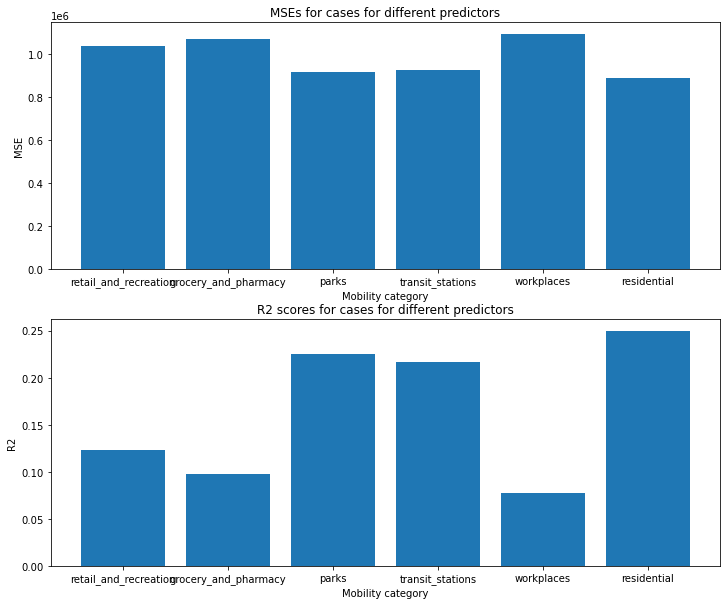

In [348]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(predictors_list, train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(predictors_list, train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

As expected, the trend that parks and transit stations are better remains. This time it is even more prominent.

This model is not much better. Let's start predicting using average day mobility.

In [349]:
predictors_list

['retail_and_recreation',
 'grocery_and_pharmacy',
 'parks',
 'transit_stations',
 'workplaces',
 'residential']

<div class="exercise"><b>PART 2.</b> Let's look at 7-day average mobility.</div>

In [350]:
mobility_predictors_all = predictors_list.copy()
mobility_predictors_all.append('retail_and_recreation_7day_ave')
mobility_predictors_all.append('grocery_and_pharmacy_7day_ave')
mobility_predictors_all.append('parks_7day_ave')
mobility_predictors_all.append('transit_stations_7day_ave')
mobility_predictors_all.append('workplaces_7day_ave')
mobility_predictors_all.append('residential_7day_ave')

In [351]:
print(mobility_predictors_all)

['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'retail_and_recreation_7day_ave', 'grocery_and_pharmacy_7day_ave', 'parks_7day_ave', 'transit_stations_7day_ave', 'workplaces_7day_ave', 'residential_7day_ave']


In [352]:
print("The following is predicting deaths:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['deaths'], y_test['deaths'], mobility_predictors_all)

The following is predicting deaths:

The MSE is 73.45615190806119 for train
r^2 is 0.7398569730996702 for train

The MSE is 1369.3174605188726 for test
r^2 is -3.8982963314738655 for test


In [353]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases'], y_test['cases'], mobility_predictors_all)

The following is predicting cases:

The MSE is 208468.72851856024 for train
r^2 is 0.8238113248651141 for train

The MSE is 2599950.072694367 for test
r^2 is -1.207628600980641 for test


In [354]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], mobility_predictors_all)

The following is predicting cases:

The MSE for train set on all the predictors is 18021.485897079223
r^2 on all the predictors is 0.9847690262864258 for train

The MSE for test set on all the predictors is 129085.91841673768
r^2 on all the predictors is 0.8903926008143221 for test


So what we see here is a negative r^2 for test, which means that our model is actually terrible. Let's try predicting on just the 7-day avg mobility predictors and see what happens.

In [355]:
mobility_predictors = ['retail_and_recreation_7day_ave', 'grocery_and_pharmacy_7day_ave', 'parks_7day_ave', 'transit_stations_7day_ave', 'workplaces_7day_ave', 'residential_7day_ave']

In [356]:
print("The following is predicting deaths:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['deaths'], y_test['deaths'], mobility_predictors)

The following is predicting deaths:

The MSE is 147.59904703971114 for train
r^2 is 0.477281863164127 for train

The MSE is 156.471042417011 for test
r^2 is 0.4402747681587946 for test


In [357]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases'], y_test['cases'], mobility_predictors)

The following is predicting cases:

The MSE is 523763.53165466926 for train
r^2 is 0.5573379116283663 for train

The MSE is 598027.3731314794 for test
r^2 is 0.49221242863090464 for test


We again see a relatively nice r^2. Again this shows how using our mobility predictors to predict cases results in a better and more accurate model.

This is overall much better. Previously, when we just used the 6 mobility predictors to predict deaths, we got that the train MSE was around 174, while the test MSE was around 198. We also got that the train r^2 is around 0.383 and the test r^2 is around 0.291. Now, we see much better results.

The same is true for cases. Before, we had around 666000 MSE for train and 811000 for test, and an r^2 of about 0.437 for train and 0.312 for test. Again, using these 7-day averages makes our model better.

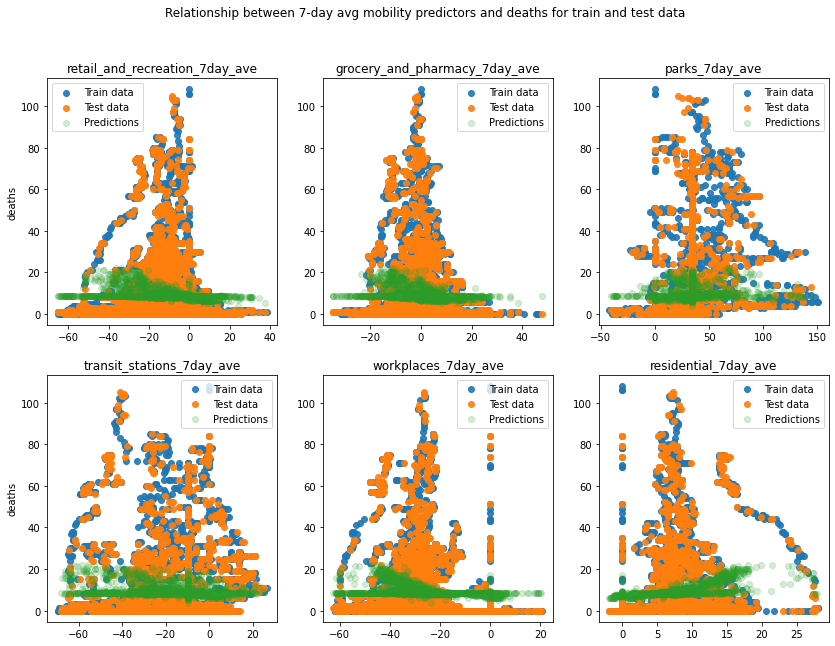

In [358]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 7-day avg mobility predictors and deaths for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[mobility_predictors[i]], y_train['deaths'], alpha=0.9, label="Train data")
    ax.scatter(X_test[mobility_predictors[i]], y_test['deaths'], alpha=0.9, label="Test data")
    ax.scatter(X_test[mobility_predictors[i]], y_pred_test, alpha=0.2, label="Predictions")
    ax.set_title(mobility_predictors[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    ax.legend()

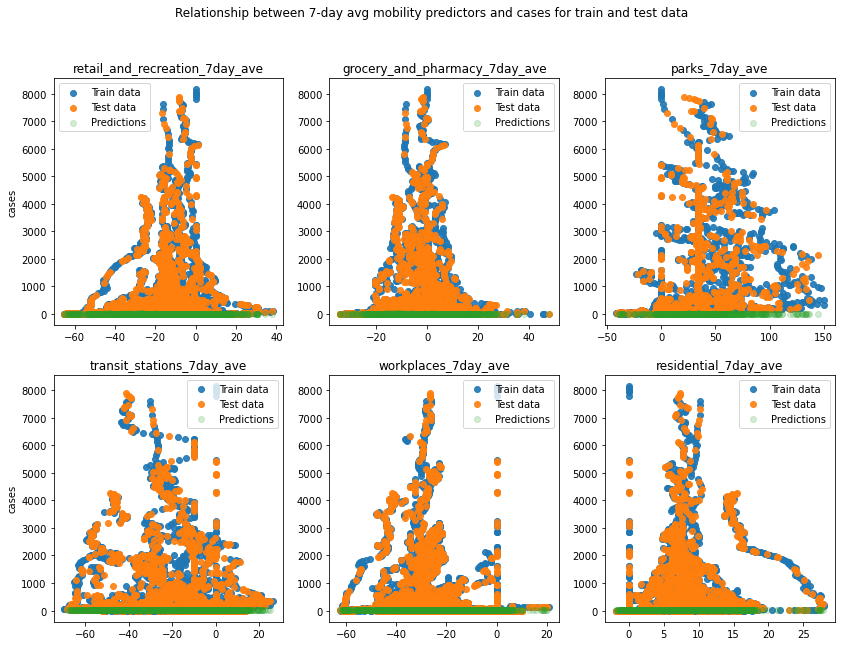

In [359]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 7-day avg mobility predictors and cases for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[mobility_predictors[i]], y_train['cases'], alpha=0.9, label="Train data")
    ax.scatter(X_test[mobility_predictors[i]], y_test['cases'], alpha=0.9, label="Test data")
    ax.scatter(X_test[mobility_predictors[i]], y_pred_test, alpha=0.2, label="Predictions")
    ax.set_title(mobility_predictors[i])
    if i == 0 or i == 3:
        ax.set_ylabel("cases")
    i += 1
    ax.legend()

Now let's fit a bagging regressor model using all 7-day average predictors.

In [360]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], mobility_predictors)

The following is predicting cases:

The MSE for train set on all the predictors is 82199.44582874332
r^2 on all the predictors is 0.9305286142420219 for train

The MSE for test set on all the predictors is 135741.1976891229
r^2 on all the predictors is 0.8847415750413521 for test


Previously, when predicting on current day mobility, we saw MSE on train data around 52000, and an MSE on test data of about 351000. Meanwhile, the r^2 on train was about 0.955, and on the test data was around 0.70. So, what we observe is that while the train r^2 decreased a little, the r^2 on test data increased from around 70% to almost 90%, which is a good improvement.

In [361]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], 
                                                                [mobility_predictors[i]], verbose=False)

    bagg_mses_train.update([(mobility_predictors[i], train_mse)])
    bagg_mses_test.update([(mobility_predictors[i], test_mse)])
    
    bagg_r2_train.update([(mobility_predictors[i], train_r2)])
    bagg_r2_test.update([(mobility_predictors[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,969209.614038,1.007422e+06,714618.273202,787596.146668,1.047290e+06,862444.151901
R2,0.180866,1.485713e-01,0.396036,0.334358,1.148763e-01,0.271100


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.074997e+06,1.077531e+06,1.121099e+06,1.075007e+06,1.089397e+06,929301.135090
R2,8.721582e-02,8.506424e-02,4.807018e-02,8.720723e-02,7.498803e-02,0.210926


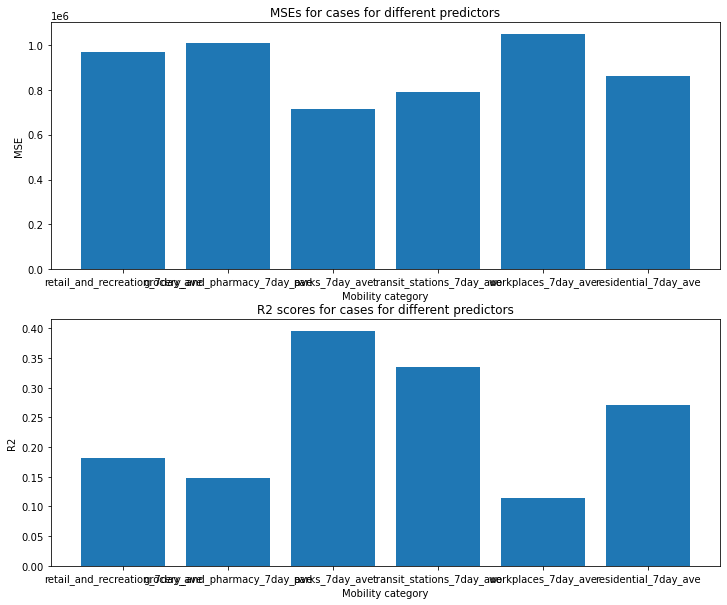

In [362]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(mobility_predictors, train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(mobility_predictors, train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

Again, we see the trend that parks, transit stations, and residential mobility tend to be the better predictors of the 6.

<div class="exercise"><b>PART 3.</b> Let's look at 7-day average mobility, and also include facemask data.</div>

In [364]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,facemask_score
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,...,2.571429,1.428571,-3.428571,1.714286,0.042,0.05,0.049,0.196,0.663,4.388
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,...,2.714286,1.428571,-3.000000,1.571429,0.042,0.05,0.049,0.196,0.663,4.388


In [365]:
facemask_predictors = ['facemask_never', 'facemask_rarely', 'facemask_sometimes', 'facemask_frequently', 'facemask_always', 'facemask_score']

In [366]:
# combine these and 7-day Avg mobility into a new list.
all_predictors = mobility_predictors + facemask_predictors

In [367]:
all_predictors

['retail_and_recreation_7day_ave',
 'grocery_and_pharmacy_7day_ave',
 'parks_7day_ave',
 'transit_stations_7day_ave',
 'workplaces_7day_ave',
 'residential_7day_ave',
 'facemask_never',
 'facemask_rarely',
 'facemask_sometimes',
 'facemask_frequently',
 'facemask_always',
 'facemask_score']

In [368]:
print("The following is predicting deaths:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['deaths'], y_test['deaths'], all_predictors)

The following is predicting deaths:

The MSE is 10.993848848997263 for train
r^2 is 0.9610655739162264 for train

The MSE is 39.16439186824006 for test
r^2 is 0.8599018835705841 for test


Previously, when just using the 7-day averages, we got that:

The MSE is 147.59904703971114 for train and r^2 is 0.477281863164127 for train. The MSE is 156.471042417011 for test and r^2 is 0.4402747681587946 for test.

Now, we get a much better result when including facemasks.

In [369]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases'], y_test['cases'], all_predictors)

The following is predicting cases:

The MSE is 39430.20022307539 for train
r^2 is 0.9666753148686834 for train

The MSE is 154233.413093113 for test
r^2 is 0.8690397567448811 for test


Again, including facemasks in our data creates a much better model. Without facemasks, when predicting cases, we saw:

The MSE is 523763.53165466926 for train and r^2 is 0.5573379116283663 for train. The MSE is 598027.3731314794 for test and r^2 is 0.49221242863090464 for test.

In [370]:
print("The following is predicting deaths:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['deaths'], y_test['deaths'], all_predictors)

The following is predicting deaths:

The MSE for train set on all the predictors is 7.448474619151839
r^2 on all the predictors is 0.9736214233541439 for train

The MSE for test set on all the predictors is 27.28338462026522
r^2 on all the predictors is 0.9024023963405865 for test


In [371]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], all_predictors)

The following is predicting cases:

The MSE for train set on all the predictors is 31302.5571072704
r^2 on all the predictors is 0.9735444442710598 for train

The MSE for test set on all the predictors is 144195.8552223482
r^2 on all the predictors is 0.8775626895781777 for test


Previously, when predicting cases, we saw:

The MSE for train set on all the predictors is 81208.11053187553 and r^2 on all the predictors is 0.9313664475890701 for train.

The MSE for test set on all the predictors is 132420.9887729016 and r^2 on all the predictors is 0.8875607784720876 for test.


In [372]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(len(all_predictors[0:6])):
    
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], 
                                                                [all_predictors[i]], verbose=False)

    bagg_mses_train.update([(all_predictors[i], train_mse)])
    bagg_mses_test.update([(all_predictors[i], test_mse)])
    
    bagg_r2_train.update([(all_predictors[i], train_r2)])
    bagg_r2_test.update([(all_predictors[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,969252.808532,1.007312e+06,714380.963513,787993.920068,1.047290e+06,862383.608620
R2,0.180830,1.486635e-01,0.396236,0.334022,1.148765e-01,0.271151


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.075364e+06,1.079189e+06,1.134216e+06,1.076344e+06,1.090647e+06,928800.567253
R2,8.690378e-02,8.365633e-02,3.693208e-02,8.607149e-02,7.392688e-02,0.211352


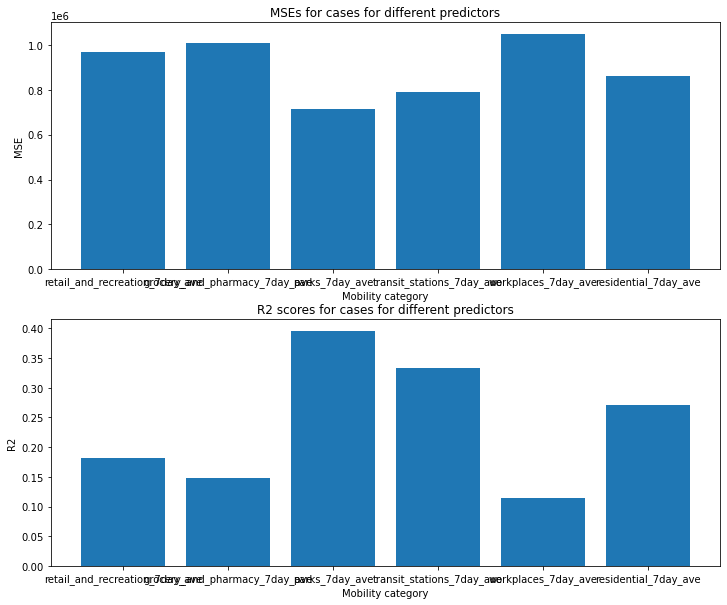

In [373]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(all_predictors[0:6], train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(all_predictors[0:6], train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

Let's look at 7-day average mobility, but with the facemask data.

In [374]:
facemask_predictors

['facemask_never',
 'facemask_rarely',
 'facemask_sometimes',
 'facemask_frequently',
 'facemask_always',
 'facemask_score']

In [375]:
mobility_predictors

['retail_and_recreation_7day_ave',
 'grocery_and_pharmacy_7day_ave',
 'parks_7day_ave',
 'transit_stations_7day_ave',
 'workplaces_7day_ave',
 'residential_7day_ave']

In [376]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(len(mobility_predictors)):
    list_of_predictors = [mobility_predictors[i]] + facemask_predictors
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], 
                                                                list_of_predictors, verbose=False)

    bagg_mses_train.update([(mobility_predictors[i], train_mse)])
    bagg_mses_test.update([(mobility_predictors[i], test_mse)])
    
    bagg_r2_train.update([(mobility_predictors[i], train_r2)])
    bagg_r2_test.update([(mobility_predictors[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,181478.584131,241559.162132,211561.537357,185647.163753,158571.160365,154376.386645
R2,0.846622,0.795845,0.821197,0.843099,0.865983,0.869528


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,539849.047623,625867.583173,771965.965149,497910.713038,459646.008580,362473.748303
R2,0.541612,0.468573,0.344520,0.577222,0.609713,0.692222


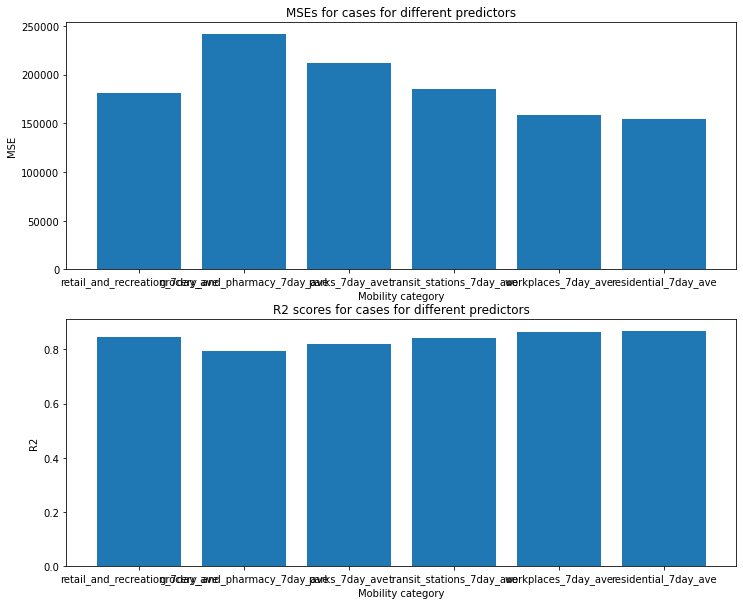

In [377]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(mobility_predictors, train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(mobility_predictors, train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

In [379]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(len(mobility_predictors)):
    list_of_predictors = [mobility_predictors[i]] + [facemask_predictors[5]]
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases'], y_test['cases'], 
                                                                list_of_predictors, verbose=False)

    bagg_mses_train.update([(mobility_predictors[i], train_mse)])
    bagg_mses_test.update([(mobility_predictors[i], test_mse)])
    
    bagg_r2_train.update([(mobility_predictors[i], train_r2)])
    bagg_r2_test.update([(mobility_predictors[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,179239.476804,241724.962338,211009.302151,185934.409498,159119.127386,153894.145555
R2,0.848515,0.795705,0.821664,0.842856,0.865519,0.869935


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,540107.719028,635619.672268,777592.244247,502051.423726,446433.069482,369284.704842
R2,0.541392,0.460293,0.339743,0.573706,0.620932,0.686439


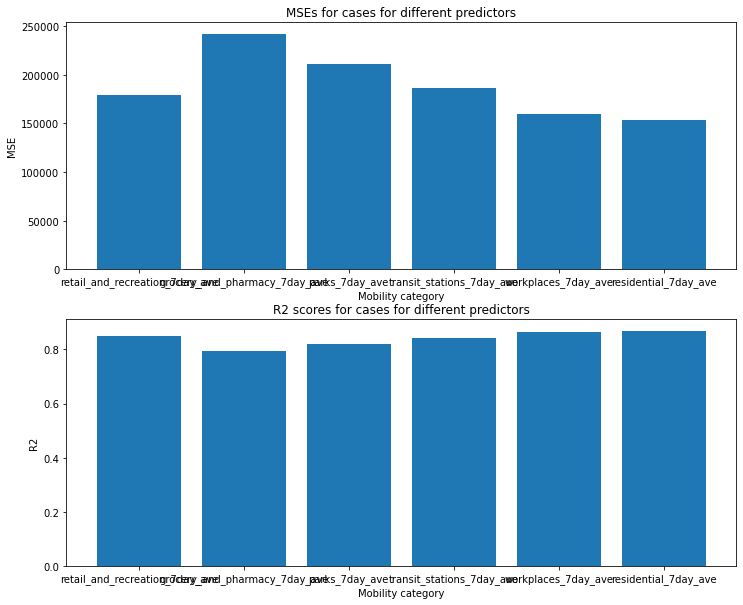

In [380]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(mobility_predictors, train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(mobility_predictors, train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()